# 基于线性层的自编码模型

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hiddenlayer as hl
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

## 自编码网络数据准备

In [2]:
# 使用手写体数据，准备训练数据集
train_data = MNIST(
    root = './data/MNIST/',
    train = True,
    transform = transforms.ToTensor(),
    download = False,
)

# 将图像数据转化为向量数据
train_data_x = train_data.data.type(torch.FloatTensor) / 255.0
train_data_x = train_data_x.reshape(train_data_x.shape[0], -1)
train_data_y = train_data.targets

# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data_x,
    batch_size = 64,
    shuffle = True,
    num_workers = 2,
)

# 对测试数据就进行导入
test_data = MNIST(
    root = './data/MNIST/',
    train = False,
    transform = transforms.ToTensor(),
    download = False,
)

# 为测试数据添加一个通道维度，获取测试数据的X和Y
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0
test_data_x = test_data_x.reshape(test_data_x.shape[0], -1)
test_data_y = test_data.targets

print("训练数据集:", train_data_x.shape)
print("测试数据集:", test_data_x.shape)

训练数据集: torch.Size([60000, 784])
测试数据集: torch.Size([10000, 784])


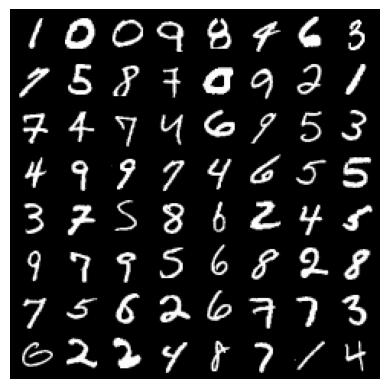

In [3]:
# 可视化一个batch的图像内容，获得一个batch的数据
for step, b_x in enumerate(train_loader):
    if step > 0:
        break
        
# 可视化一个batch的图像
im = make_grid(b_x.reshape((-1, 1, 28, 28)))
im = im.data.numpy().transpose((1, 2, 0))
plt.figure()
plt.imshow(im)
plt.axis("off")
plt.show()

## 自编码网络的构建

In [4]:
class EnDecoder(nn.Module):
    def __init__(self):
        super(EnDecoder, self).__init__()
            
        # 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 3),
            nn.Tanh(),
        )
        
        # 定义Decoder
        self.Decoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 512),
            nn.Tanh(),
            nn.Linear(512, 784),
            nn.Tanh(),      
        )
        
    # 定义网络的前向传播路径
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder, decoder

In [5]:
# 输出网络结构
edmodel = EnDecoder()
print(edmodel)

EnDecoder(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=3, bias=True)
    (7): Tanh()
  )
  (Decoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)


## 自编码网络的训练

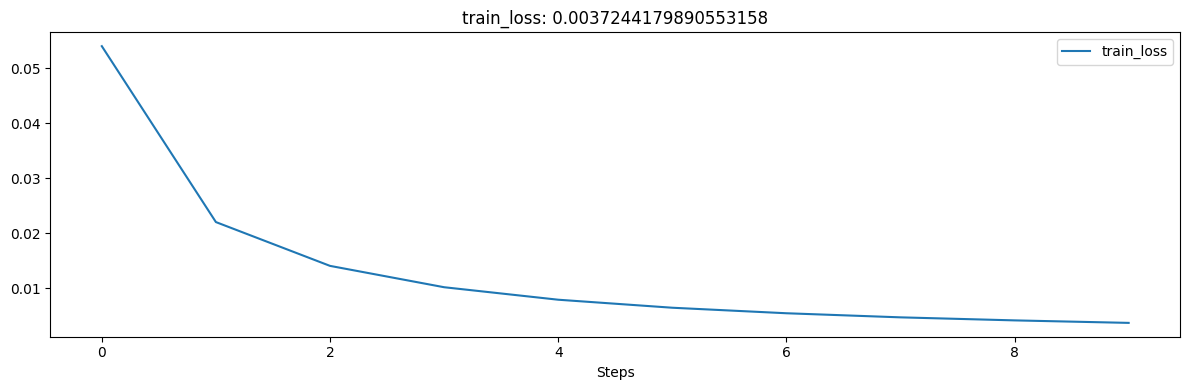

In [6]:
# 定义优化器
optimizer = torch.optim.Adam(edmodel.parameters(), lr=0.003)
loss_func = nn.MSELoss()

# 记录训练过程的指标
history1 = hl.History()

# 使用Canvas进行可视化
canvas1 = hl.Canvas()

train_num = 0
val_num = 0

# 对模型进行迭代训练对所有的数据训练epoch轮
for epoch in range(10):
    train_loss_epoch = 0
    
    # 对训练数据的加载器进行迭代计算
    for step, b_x in enumerate(train_loader):
        # 计算每个batch的损失
        _, output = edmodel(b_x)
        loss = loss_func(output, b_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num + b_x.size(0)
        
    # 计算一个epoch的损失和精度
    train_loss = train_loss_epoch / train_num
    
    # 保存每个epoch上的输出loss
    history1.log(epoch, train_loss=train_loss)
    
    # 可视化网络训练的过程
    with canvas1:
        canvas1.draw_plot(history1['train_loss'])

## 自编码网络的数据重构

<function matplotlib.pyplot.show(close=None, block=None)>

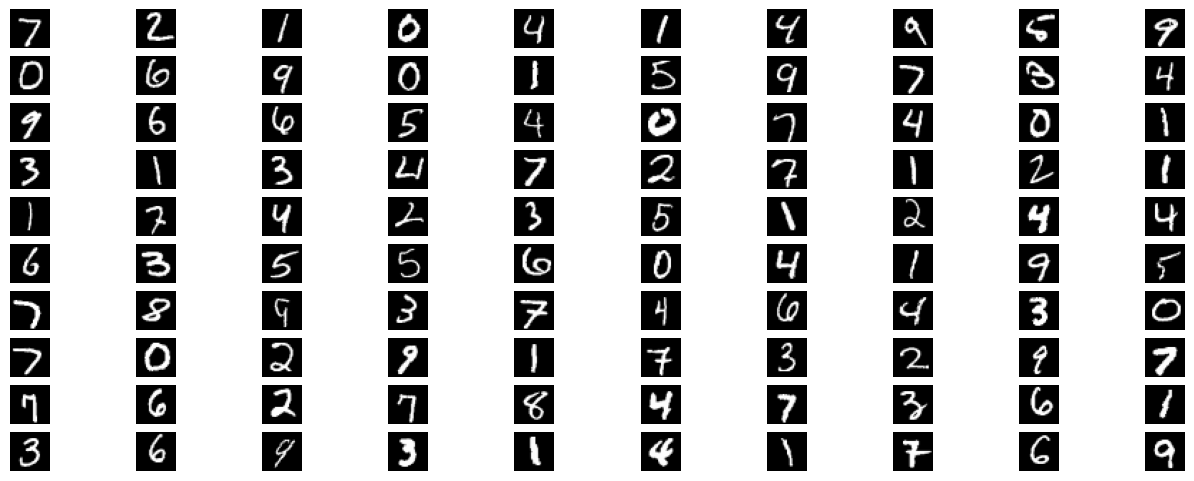

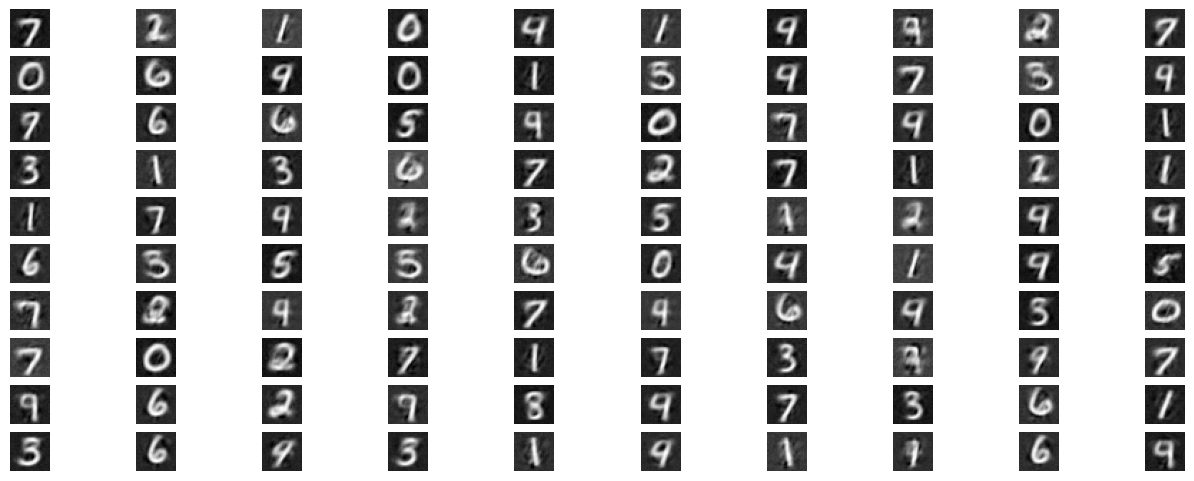

In [7]:
# 预测测试集前100张图象的输出
edmodel.eval()
_, test_decoder = edmodel(test_data_x[0:100, :])

# 可视化原始的图像
plt.figure(figsize=(16, 6))
for ii in range(test_decoder.shape[0]):
    plt.subplot(10, 10, ii+1)
    im = test_data_x[ii, :]
    im = im.data.numpy().reshape(28, 28)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis("off")
plt.show

# 可视化编码后的图像
plt.figure(figsize=(16, 6))
for ii in range(test_decoder.shape[0]):
    plt.subplot(10, 10, ii+1)
    im = test_decoder[ii, :]
    im = im.data.numpy().reshape(28, 28)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.axis("off")
plt.show

## 网络的编码特征可视化

In [10]:
# 获取前500个样本的自编码后的特征，并对数据进行可视化
edmodel.eval()
TEST_num = 500
test_encoder, _ = edmodel(test_data_x[0:TEST_num, :])
print("test_encoder,shape:", test_encoder.shape)

test_encoder,shape: torch.Size([500, 3])


In [18]:
%config InlineBackend.print_figure_kwargs = {'bbox_inchea': None}
# 将三个维度的特征进行可视化
test_encoder_arr = test_encoder.data.numpy()
fig = plt.figure(figsize=(12, 8))
ax1 = Axes3D(fig)

X = test_encoder_arr[:, 0]
Y = test_encoder_arr[:, 1]
Z = test_encoder_arr[:, 2]
ax1.set_xlim([min(X), max(X)])
ax1.set_ylim([min(Y), max(Y)])
ax1.set_zlim([min(Z), max(Z)])

for ii in range(test_encoder.shape[0]):
    text = test_data_y.data.numpy()[ii]
    ax1.text(X[ii], Y[ii], Z[ii], str(text),
            bbox=dict(boxstyle="round", facecolor=plt.cm.Set1(text), alpha=0.7))
    
plt.show()

<Figure size 1200x800 with 0 Axes>

## SVM作用于编码特征

# 卷积自编码图像去噪

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from sklearn.model_selection import train_test_split
from skimage.util import random_noise
# from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import STL10

## 去噪自编码网络的数据准备

In [29]:
#  定义一个将bin文件处理为图像数据的函数
def read_image(data_path):
    with open(data_path, 'rb') as f:
        data1 = np.fromfile(f, dtype=np.uint8)
        # 图像[数量， 通道， 宽， 高]
        images = np.reshape(data1, (-1, 3, 96, 96))
        # 将图像转化为RGB形式。方便使用matplotlib进行可视化
        images = np.transpose(images, (0, 3, 2, 1))
        
    # 输出的图像取值在0-1之间
    return images / 255.0

In [30]:
# 读取训练数据集，5000张96*96*3的图像
data_path = './data/stl10_binary/train_X.bin'
images = read_image(data_path)
print("images.shape:", images.shape)

images.shape: (5000, 96, 96, 3)


In [31]:
# 为数据添加高斯噪声
def gaussian_noise(images, sigma):
    "sigma:噪声标准差"
    sigma2 = sigma ** 2 / (255**2)  # 噪声方差
    images_noisy = np.zeros_like(images)
    for ii in range(images.shape[0]):
        image = images[ii]
        
        # 使用skimage库中的random_noise函数添加噪声
        noise_im = random_noise(image, mode="gaussian", var=sigma2, clip=True)
        images_noisy[ii] = noise_im
    return images_noisy

images_noise = gaussian_noise(images, 30)
print("images_noise:", images_noise.min(), "~", images_noise.max())

images_noise: 0.0 ~ 1.0


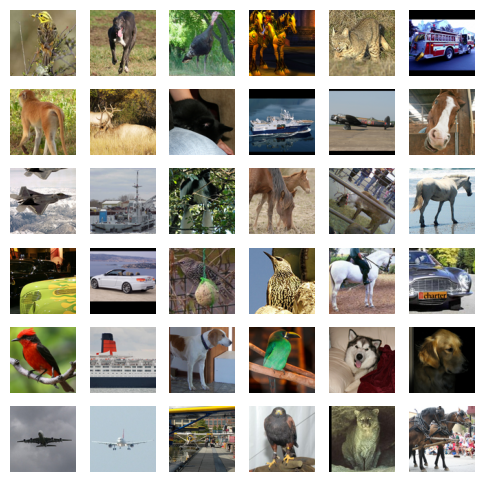

--------------------------------------------------


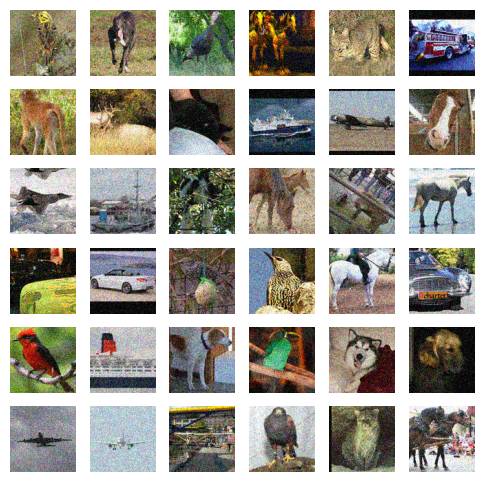

In [32]:
# 可视化其中的部分图像，不带噪声的图像
plt.figure(figsize=(6, 6))
for ii in np.arange(36):
    plt.subplot(6, 6, ii+1)
    plt.imshow(images[ii,...])
    plt.axis('off')
plt.show()
print("-" * 50)
# 带噪声的图像
plt.figure(figsize=(6, 6))
for ii in np.arange(36):
    plt.subplot(6, 6, ii+1)
    plt.imshow(images_noise[ii,...])
    plt.axis('off')
plt.show()

In [33]:
# 数据准备为PyTorch可用的形式，转化为[样本，通道，高，宽]的数据形式
data_Y = np.transpose(images, (0, 3, 2, 1))
data_X = np.transpose(images_noise, (0, 3, 2, 1))

# 将数据集切分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(data_X, data_Y, test_size=0.2, random_state=123)

# 将图像数据转化为向量数据
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# 将X和Y转化为数据集合
train_data = Data.TensorDataset(X_train, y_train)
val_data = Data.TensorDataset(X_val, y_val)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)

X_train.shape: torch.Size([4000, 3, 96, 96])
y_train.shape: torch.Size([4000, 3, 96, 96])
X_val.shape: torch.Size([1000, 3, 96, 96])
y_val.shape: torch.Size([1000, 3, 96, 96])


In [34]:
# 定义一个数据加载器
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
)

# 定义一个数据加载器
val_loader = Data.DataLoader(
    dataset = val_data,
    batch_size = 32,
    shuffle = True,
    num_workers = 4,
)

## 基于转置卷积解码的网络搭建

In [35]:
class DenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoEncoder, self).__init__()
        
        # 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),                         # [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 3, 1, 1), # [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 3, 1, 1), # [,64,96,96]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),          # [,64,48,48]
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, 1, 1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 128, 3, 1, 1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 3, 1, 1), # [,256,48,48]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # [,256,24,24]
            nn.BatchNorm2d(256),
        )
        
        # 定义Decoder
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),                            # [,256,24,24]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 128, 3, 2, 1, 1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, 3, 1, 1), # [,64,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, 3, 1, 1), # [,32,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(32, 32, 3, 1, 1), # [,32,48,48]
            nn.ConvTranspose2d(32, 16, 3, 2, 1, 1), # [,16,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            
            nn.ConvTranspose2d(16, 3, 3, 1, 1), # [,3,96,96]
            nn.Sigmoid()
        )
        
    # 定义前向传播路径
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder, decoder

In [36]:
# 输出网络结构
DAEmodel = DenoiseAutoEncoder()
print(DAEmodel)

DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

## 基于转置卷积解码的网络训练与预测

### 网络训练

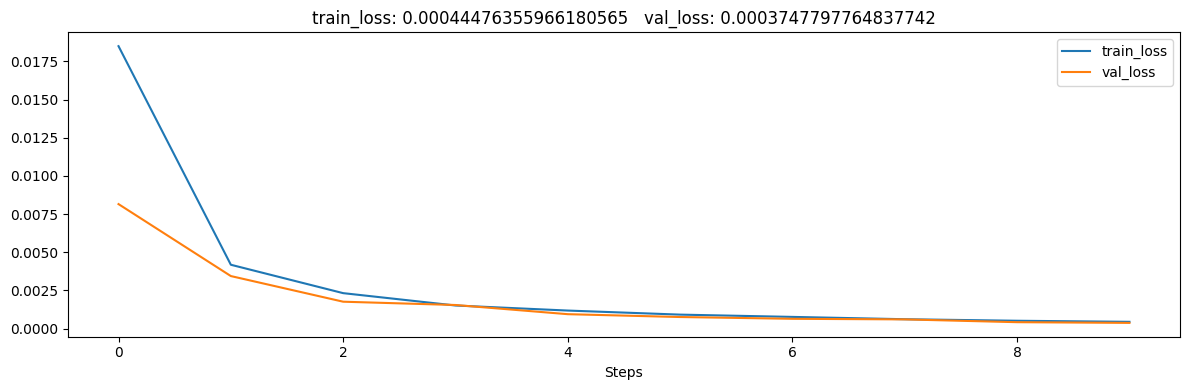

In [37]:
# 定义优化器
LR = 0.0003
optimizer = torch.optim.Adam(DAEmodel.parameters(), lr=LR)
loss_func = nn.MSELoss()

# 记录训练过程的指标
history1 = hl.History()

# 使用Canvas进行可视化
canvas1 = hl.Canvas()

train_num = 0
val_num = 0
# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        DAEmodel.train()
        # 使用每个epoch进行训练模型
        _, output = DAEmodel(b_x) # CNN在训练batch上的输出
        loss = loss_func(output, b_y) # 均方根误差
        optimizer.zero_grad() # 损失的后向传播，计算梯度
        loss.backward() # 使用梯度进行优化
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num + b_x.size(0)
        
    # 使用每个batch进行验证模型
    for step, (b_x, b_y) in enumerate(val_loader):
        DAEmodel.eval()
        # 使用每个epoch进行训练模型
        _, output = DAEmodel(b_x) # CNN在训练batch上的输出
        loss = loss_func(output, b_y) # 均方根误差
        val_loss_epoch += loss.item() * b_x.size(0)
        val_num = val_num + b_x.size(0)
        
    # 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    val_loss = val_loss_epoch / val_num
    
    # 保存每个epoch上的输出loss
    history1.log(epoch, train_loss=train_loss, val_loss=val_loss)
    
    # 可视化网络训练的过程
    with canvas1:
        canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])

### 评价网络去噪效果

In [38]:
# 输入
imageindex = 1
im = X_val[imageindex,...]
im = im.unsqueeze(0)
imnose = np.transpose(im.data.numpy(), (0, 3, 2, 1))
imnose = imnose[0,...]

# 去噪
DAEmodel.eval()
_, output = DAEmodel(im)
imde = np.transpose(output.data.numpy(), (0, 3, 2, 1))
imde = imde[0,...]

# 输出
im = y_val[imageindex,...]
imor = im.unsqueeze(0)
imor = np.transpose(imor.data.numpy(), (0, 3, 2, 1))
imor = imor[0,...]

# 计算去噪后的PSNR
print("加噪后的PSNR：", compare_psnr(imor, imnose), "dB")
print("去噪后的PSNR：", compare_psnr(imor, imde), "dB")

加噪后的PSNR： 19.462016993791767 dB
去噪后的PSNR： 24.763222374846684 dB


Text(0.5, 1.0, 'Denoise image')

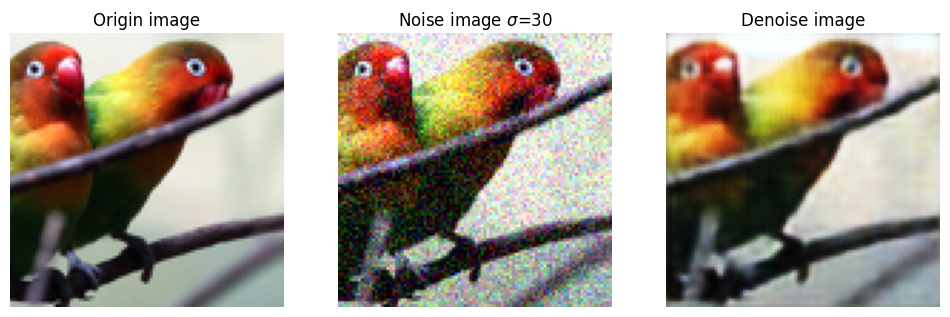

In [39]:
# 将图像可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(imor)
plt.axis("off")
plt.title("Origin image")

plt.subplot(1, 3, 2)
plt.imshow(imnose)
plt.axis("off")
plt.title("Noise image $\sigma$=30")

plt.subplot(1, 3, 3)
plt.imshow(imde)
plt.axis("off")
plt.title("Denoise image")

In [40]:
# 计算模型对整个验证集去噪后的PSNR提升量的均值
PSNR_val = []
DAEmodel.eval()
for ii in range(X_val.shape[0]):
    imageindex = ii
    
    # 输入
    im = X_val[imageindex,...]
    im = im.unsqueeze(0)
    imnose = np.transpose(im.data.numpy(), (0, 3, 2, 1))
    imnose = imnose[0,...]

    # 去噪
    _, output = DAEmodel(im)
    imde = np.transpose(output.data.numpy(), (0, 3, 2, 1))
    imde = imde[0,...]

    # 输出
    im = y_val[imageindex,...]
    imor = im.unsqueeze(0)
    imor = np.transpose(imor.data.numpy(), (0, 3, 2, 1))
    imor = imor[0,...]

    # 计算去噪后的PSNR
    PSNR_val.append(compare_psnr(imor, imde) - compare_psnr(imor, imnose))
print("PSNR的平均提升量为：", np.mean(PSNR_val), "dB")

PSNR的平均提升量为： 5.5761622023351585 dB


## 基于上采样和卷积解码的网络搭建

In [41]:
class DenoiseAutoEncoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoEncoder, self).__init__()
        
        # 定义Encoder
        self.Encoder = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),                         # [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 3, 1, 1), # [,64,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 64, 3, 1, 1), # [,64,96,96]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),          # [,64,48,48]
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, 1, 1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 128, 3, 1, 1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, 3, 1, 1), # [,256,48,48]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # [,256,24,24]
            nn.BatchNorm2d(256),
        )
        
        # 定义Decoder
        self.Decoder = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),  # [,256,48,48]
            
            nn.Conv2d(
                in_channels=256,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),                            # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 64, 3, 1, 1), # [,128,48,48]
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.UpsamplingBilinear2d(scale_factor=2),  # [,64,96,96]
            
            nn.Conv2d(64, 32, 3, 1, 1), # [,32,96,96]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 3, 3, 1, 1), # [,3,96,96]
            nn.Sigmoid()
        )
        
    # 定义前向传播路径
    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return encoder, decoder

In [42]:
# 输出网络结构
DAEmodel = DenoiseAutoEncoder()
print(DAEmodel)

DenoiseAutoEncoder(
  (Encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(128, eps=1e-05, momentum=0.1, 

## 基于上采样和卷积解码的网络训练与预测

### 网络训练

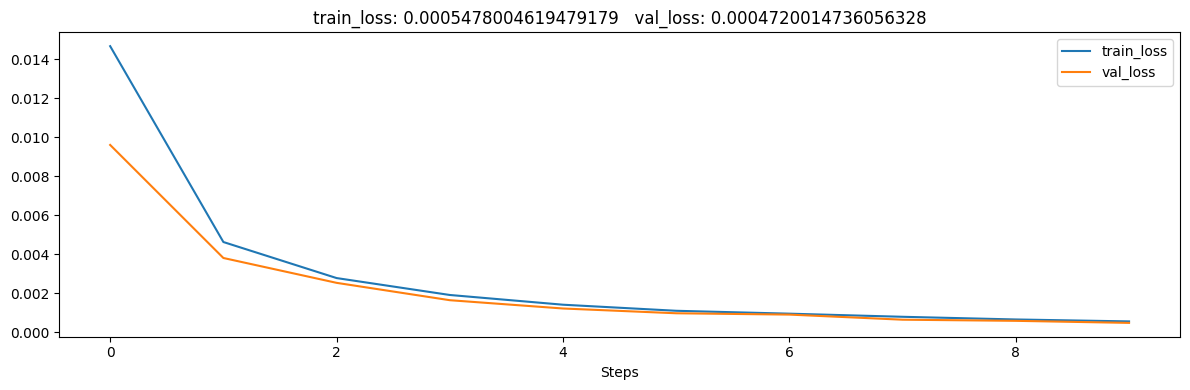

In [43]:
# 定义优化器
LR = 0.0003
optimizer = torch.optim.Adam(DAEmodel.parameters(), lr=LR)
loss_func = nn.MSELoss()

# 记录训练过程的指标
history1 = hl.History()

# 使用Canvas进行可视化
canvas1 = hl.Canvas()

train_num = 0
val_num = 0
# 对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    
    # 对训练数据的加载器进行迭代计算
    for step, (b_x, b_y) in enumerate(train_loader):
        DAEmodel.train()
        
        # 使用每个epoch进行训练模型
        _, output = DAEmodel(b_x) # CNN在训练batch上的输出
        loss = loss_func(output, b_y) # 均方根误差
        optimizer.zero_grad() # 损失的后向传播，计算梯度
        loss.backward() # 使用梯度进行优化
        optimizer.step()
        train_loss_epoch += loss.item() * b_x.size(0)
        train_num = train_num + b_x.size(0)
        
    # 使用每个batch进行验证模型
    for step, (b_x, b_y) in enumerate(val_loader):
        DAEmodel.eval()
        # 使用每个epoch进行训练模型
        _, output = DAEmodel(b_x) # CNN在训练batch上的输出
        loss = loss_func(output, b_y) # 均方根误差
        val_loss_epoch += loss.item() * b_x.size(0)
        val_num = val_num + b_x.size(0)
        
    # 计算一个epoch的损失
    train_loss = train_loss_epoch / train_num
    val_loss = val_loss_epoch / val_num
    
    # 保存每个epoch上的输出loss
    history1.log(epoch, train_loss=train_loss, val_loss=val_loss)
    
    # 可视化网络训练的过程
    with canvas1:
        canvas1.draw_plot([history1["train_loss"], history1["val_loss"]])

### 评价网络去噪效果

In [44]:
# 输入
imageindex = 1
im = X_val[imageindex,...]
im = im.unsqueeze(0)
imnose = np.transpose(im.data.numpy(), (0, 3, 2, 1))
imnose = imnose[0,...]

# 去噪
DAEmodel.eval()
_, output = DAEmodel(im)
imde = np.transpose(output.data.numpy(), (0, 3, 2, 1))
imde = imde[0,...]

# 输出
im = y_val[imageindex,...]
imor = im.unsqueeze(0)
imor = np.transpose(imor.data.numpy(), (0, 3, 2, 1))
imor = imor[0,...]

# 计算去噪后的PSNR
print("加噪后的PSNR：", compare_psnr(imor, imnose), "dB")
print("去噪后的PSNR：", compare_psnr(imor, imde), "dB")

加噪后的PSNR： 19.462016993791767 dB
去噪后的PSNR： 22.760974083081567 dB


Text(0.5, 1.0, 'Denoise image')

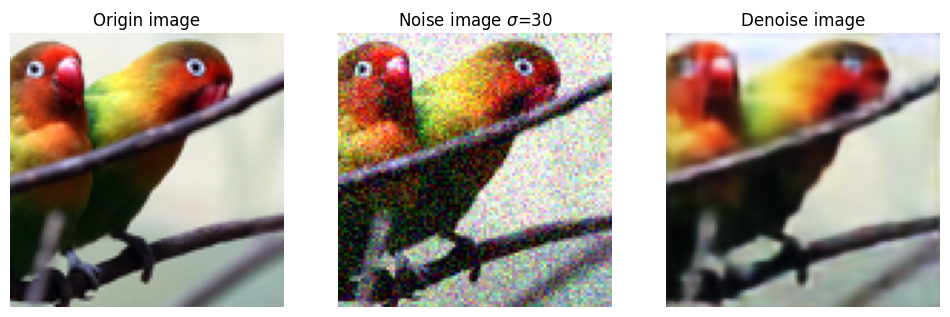

In [45]:
# 将图像可视化
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(imor)
plt.axis("off")
plt.title("Origin image")

plt.subplot(1, 3, 2)
plt.imshow(imnose)
plt.axis("off")
plt.title("Noise image $\sigma$=30")

plt.subplot(1, 3, 3)
plt.imshow(imde)
plt.axis("off")
plt.title("Denoise image")

In [46]:
# 计算模型对整个验证集去噪后的PSNR提升量的均值
PSNR_val = []
DAEmodel.eval()
for ii in range(X_val.shape[0]):
    imageindex = ii
    
    # 输入
    im = X_val[imageindex,...]
    im = im.unsqueeze(0)
    imnose = np.transpose(im.data.numpy(), (0, 3, 2, 1))
    imnose = imnose[0,...]

    # 去噪
    _, output = DAEmodel(im)
    imde = np.transpose(output.data.numpy(), (0, 3, 2, 1))
    imde = imde[0,...]
    

    # 输出
    im = y_val[imageindex,...]
    imor = im.unsqueeze(0)
    imor = np.transpose(imor.data.numpy(), (0, 3, 2, 1))
    imor = imor[0,...]

    # 计算去噪后的PSNR
    PSNR_val.append(compare_psnr(imor, imde) - compare_psnr(imor, imnose))
print("PSNR的平均提升量为：", np.mean(PSNR_val), "dB")

PSNR的平均提升量为： 4.651053338774957 dB
